In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import scipy.optimize as opt
from scipy.stats import linregress
from scipy.interpolate import interp1d

In [85]:
tables = ['probka.csv', 'Al.csv', 'Pb.csv', 'Fe.csv']
names = ['Пробка', 'Алюминий', 'Свинец', 'Железо']

layer_length_table = pd.read_csv("material_len.csv")
layer_length = {key: val for key, val in zip(names, layer_length_table['len'])}

In [86]:
def interp_func(x, bias, amplitude, base):
    return bias + amplitude * np.exp(x * base)

### Приближение экспериментальных данных экспонентой

/home/vladimir/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vladimir/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vladimir/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


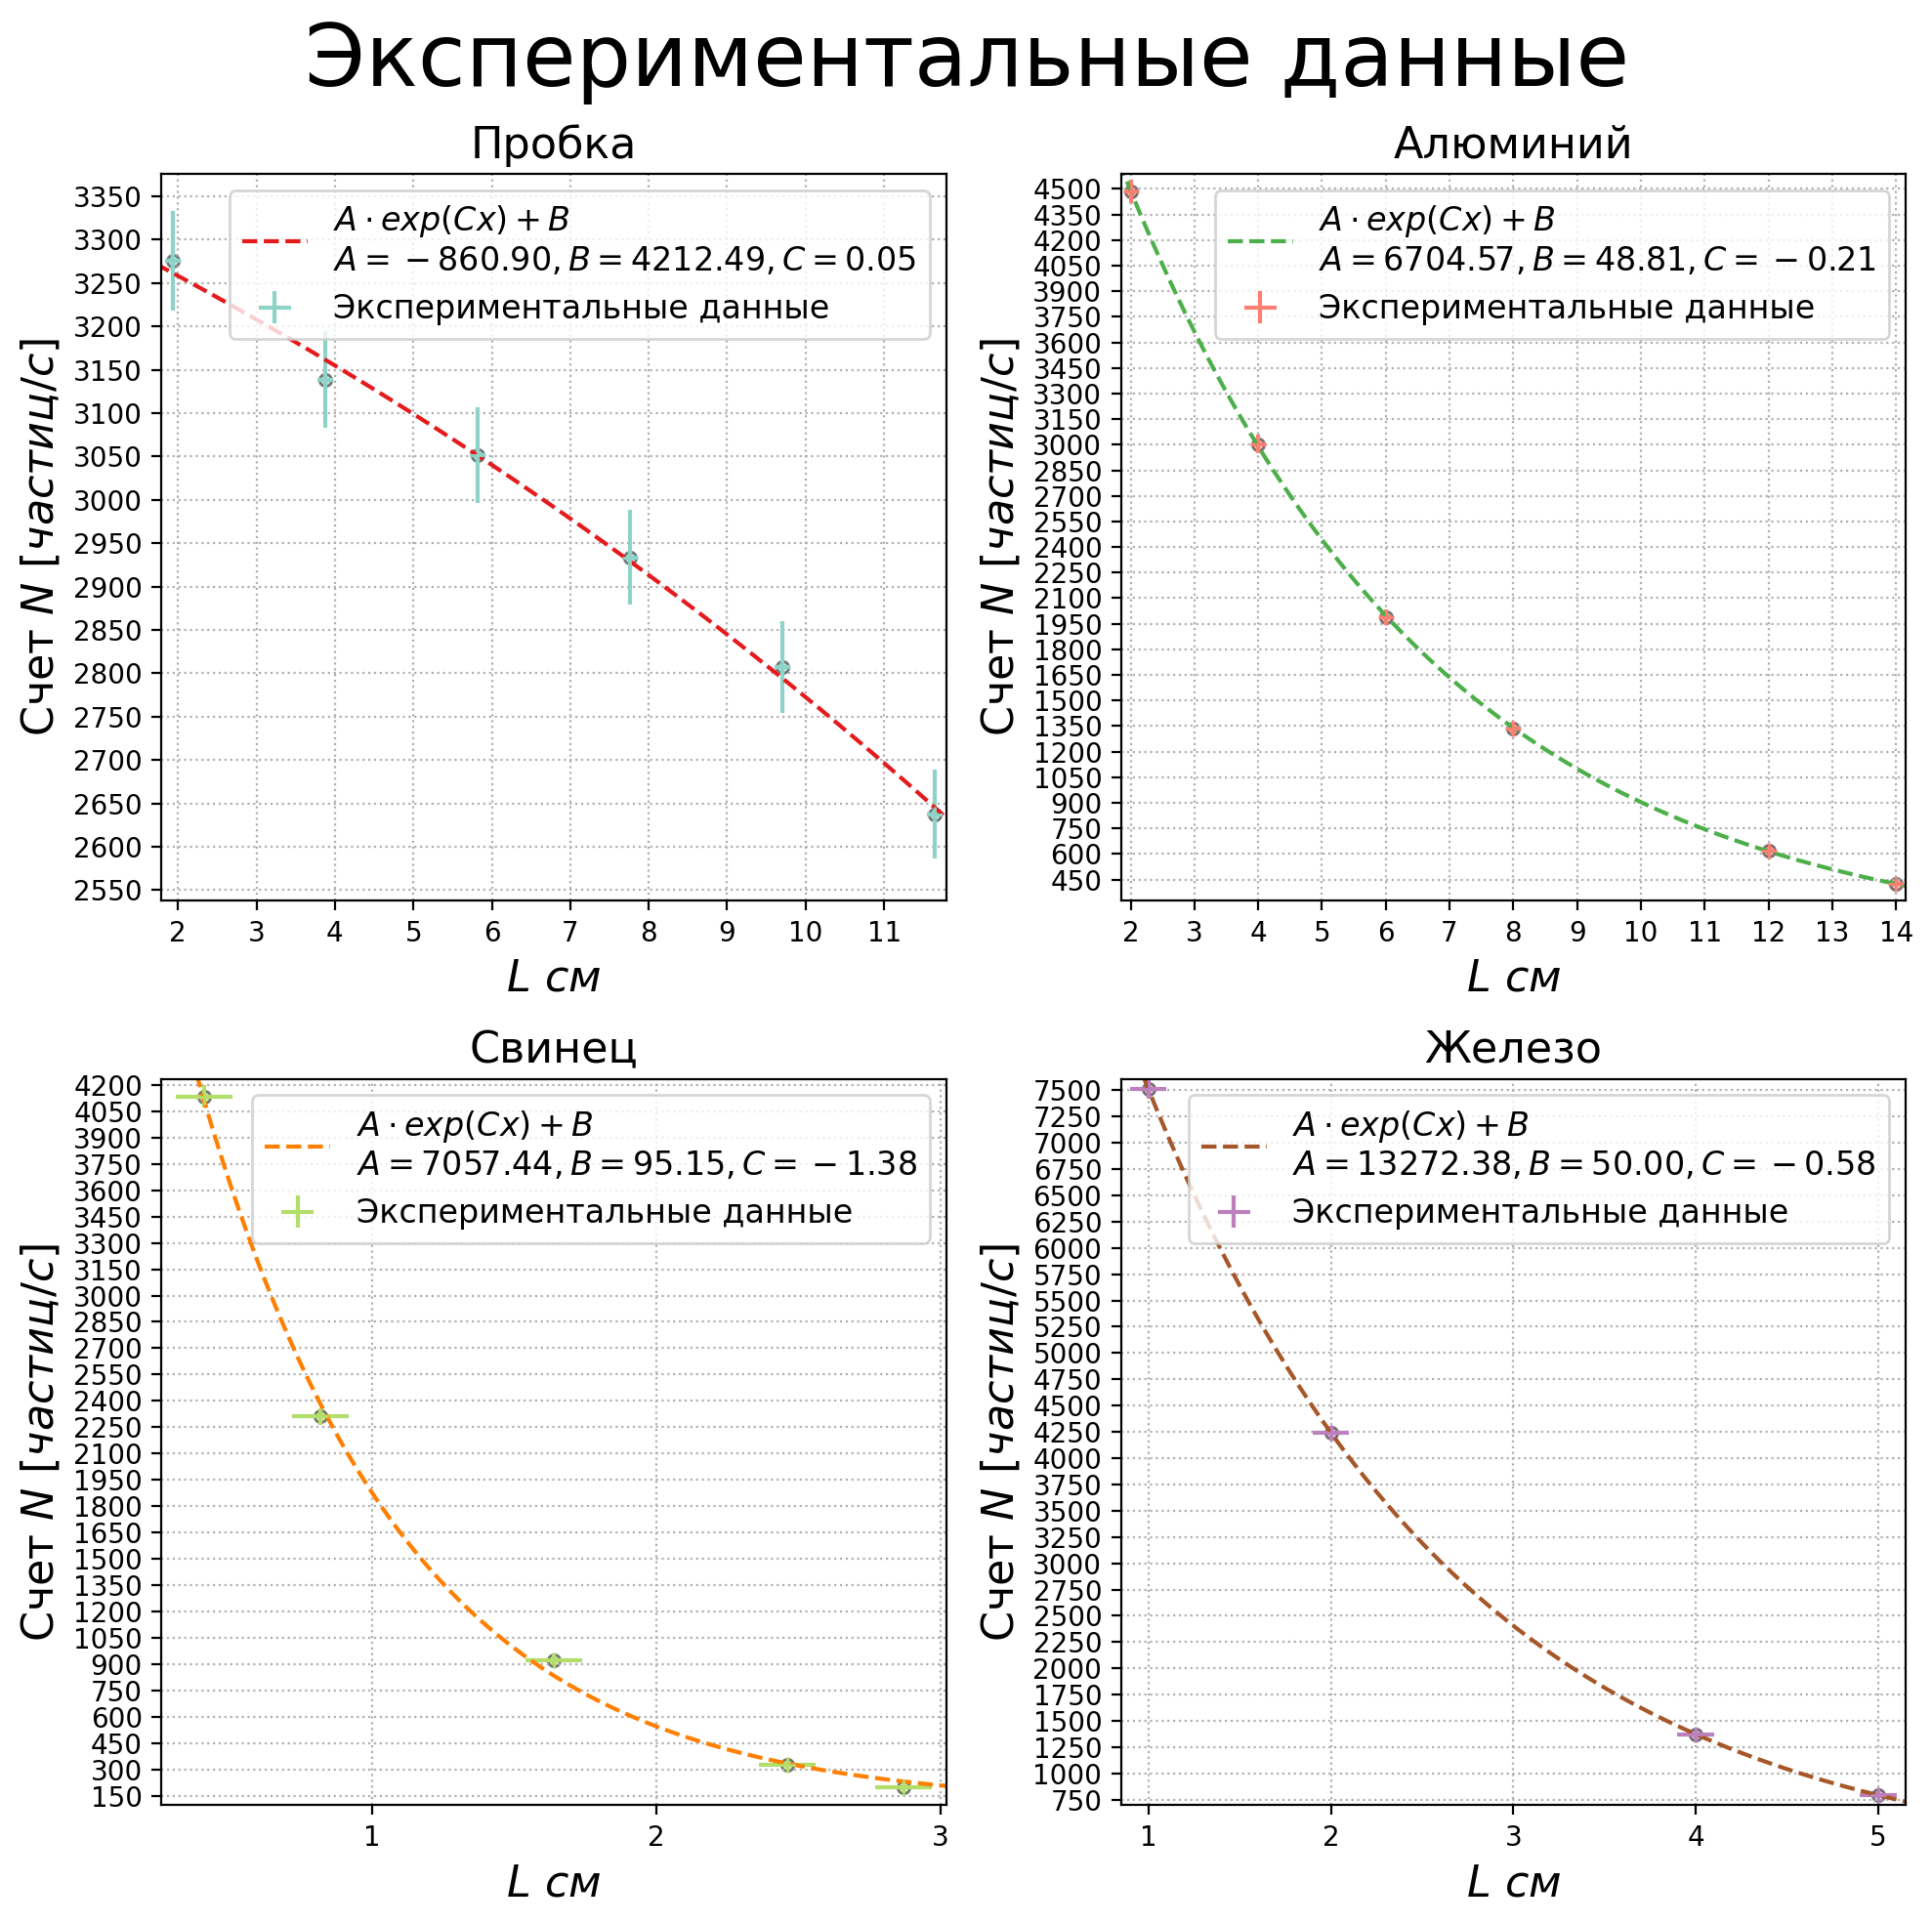

In [87]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10), dpi = 200)
color_values = np.arange(0, 2, 0.25)
step_y_values = [50, 150, 150, 250]
p0_values = [
    [200, -2, 0.5],
    [4000, 5, -3],
    [4000, 10, -20],
    [4000, 5, -3],
]

for plotable, color_interp, color_dots, name, table_name, step_y, p0 in zip(ax.ravel(), 
                                                                cm.Set1(color_values), 
                                                                cm.Set3(color_values), 
                                                                names, 
                                                                tables,
                                                                step_y_values,
                                                                p0_values):
    plotable.set_title(name, fontsize = 16)
    data = pd.read_csv(table_name)
    material_l = data['layers'] * layer_length[name]
    count = data['N'] / (data['t'] * 60)
    count_error = np.sqrt(count)
    
    param, _ = opt.curve_fit(interp_func, material_l, count, p0 = p0, maxfev = 10000)
    x_line = np.linspace(0, 20, 1000)
    xerr = [0.1 for _ in data['layers']]
    plotable.errorbar(material_l, 
                      count, 
                      color = color_dots, 
                      yerr = count_error, 
                      fmt = '+',
                      xerr = xerr,
                      label = 'Экспериментальные данные')
    plotable.plot(x_line, 
                  interp_func(x_line, *param), 
                  color = color_interp, 
                  linestyle = '--',
                  label = r'$A \cdot exp(C x) + B$' + f'\n$A = {param[1]:.2f}, B = {param[0]:.2f}, C = {param[2]:.2f}$')
    plotable.scatter(material_l, count, color = color_dots, alpha = 0.5, s = 20, edgecolor = 'k')
    plotable.grid(ls = ':')
    plotable.legend(fontsize = 12, loc = 'upper right')
    plotable.set_xticks(np.arange(0, 50, 1))
    plotable.set_xlim(np.min(material_l) - 0.15, np.max(material_l) + 0.15)
    plotable.set_yticks(np.arange(0, 20000, step_y))
    plotable.set_ylim(np.min(count) - 100, np.max(count) + 100)
    plotable.set_ylabel("Счет $N \ [частиц / c]$", fontsize = 16)
    plotable.set_xlabel('$L \ см$', fontsize = 16)
    
fig.suptitle("Экспериментальные данные", fontsize = 32)
fig.tight_layout()

### Линеаризация полученных зависимостей

In [88]:
N0 = 820565 / 60
N0_error = np.sqrt(N0)

Text(0.5, 1.0, 'Линеаризация экспериментальных зависимостей')

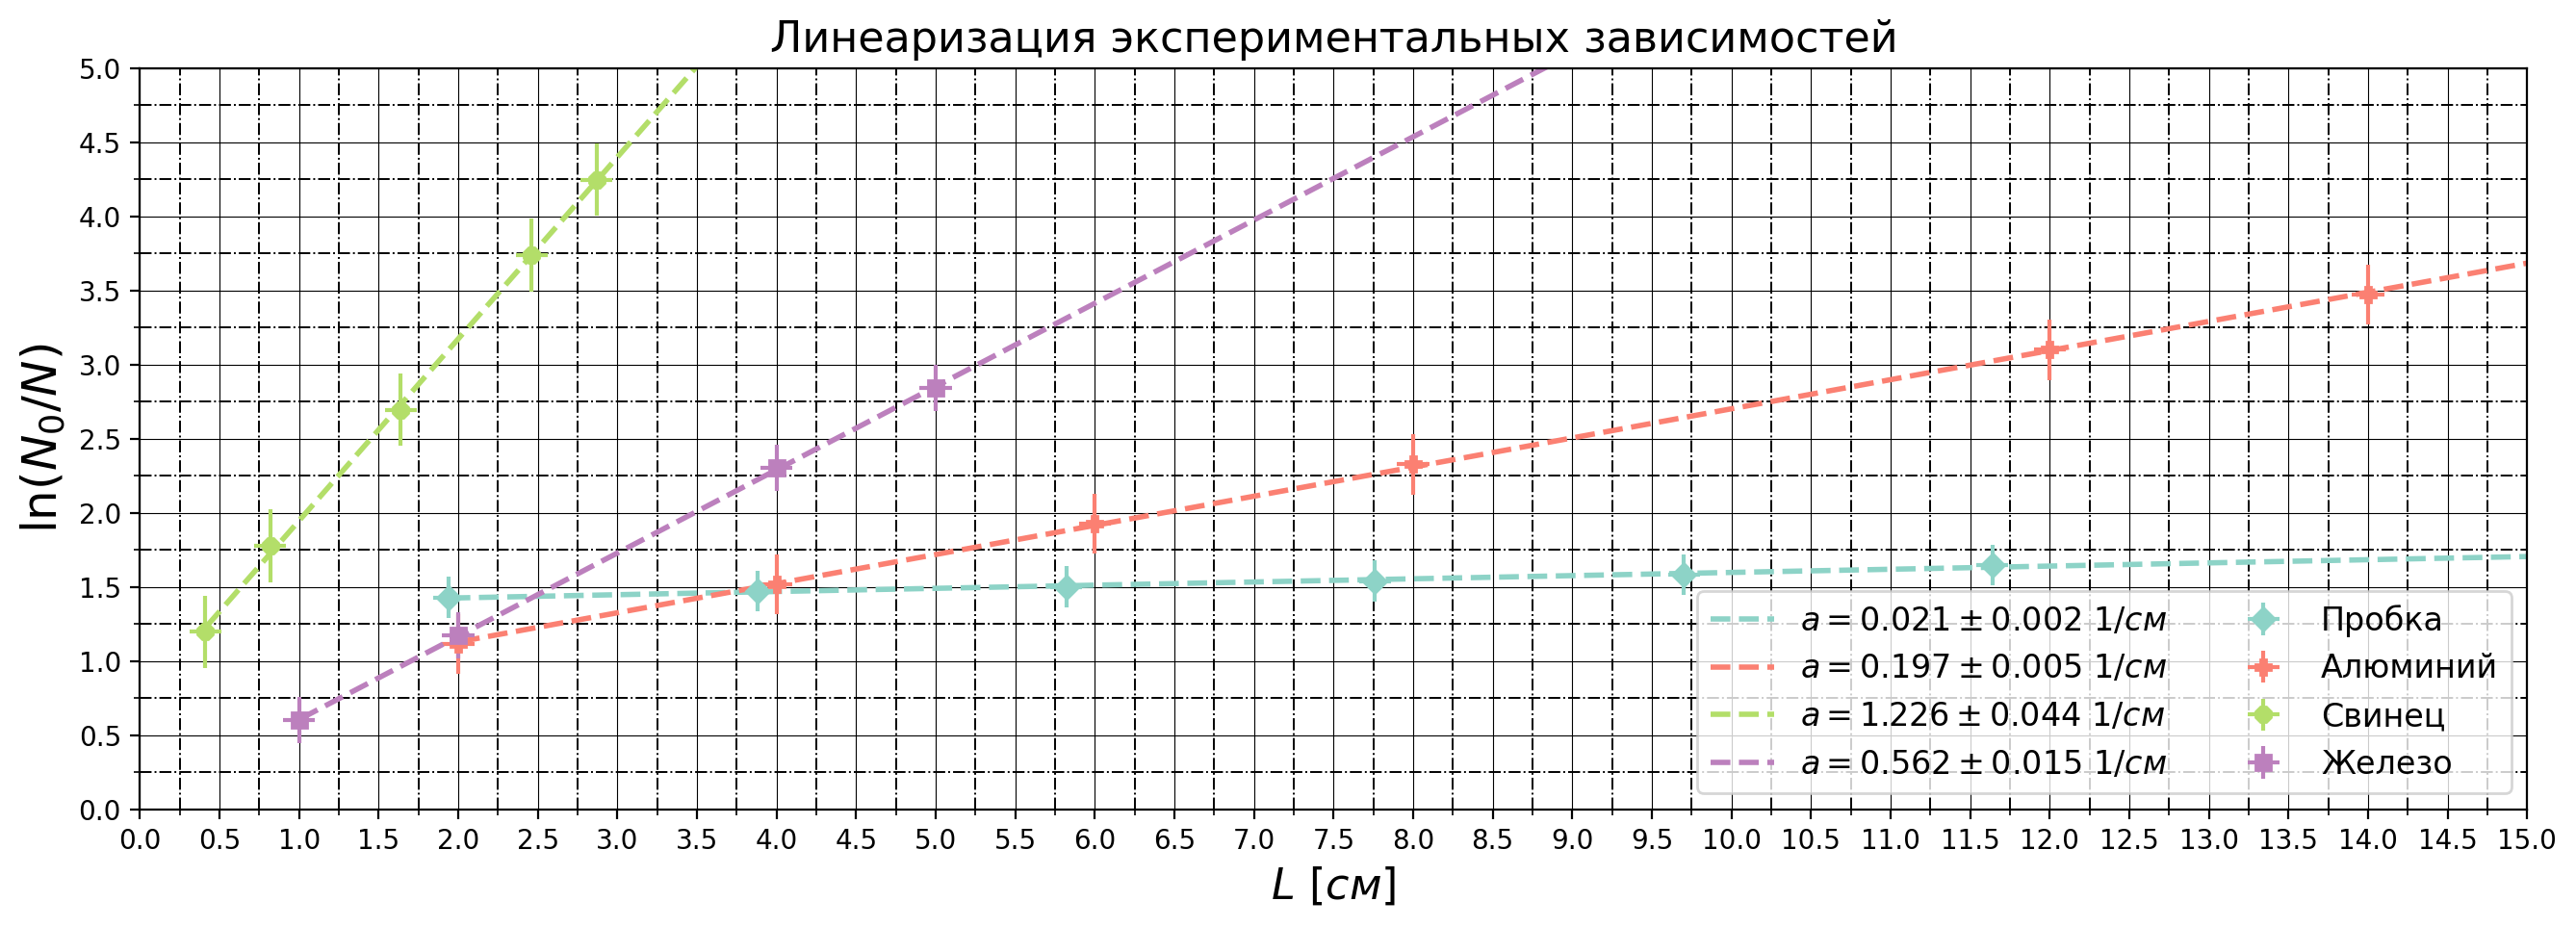

In [89]:
plt.figure(figsize = (16, 5), dpi = 200)
markers = ['D', 'P', '8', 's']
x_line = np.linspace(0, 15, 1000)
result_mu = {name: 0 for name in names}
for color, name, table_name, mark in zip(cm.Set3(color_values), 
                                   names, 
                                   tables,
                                   markers):
    data = pd.read_csv(table_name)
    material_l = data['layers'] * layer_length[name]
    count = data['N'] / (data['t'] * 60)
    count_error = np.sqrt(count)
    lnN0N = np.log(N0 / count)
    xerr = [0.1 for _ in data['layers']]
    yerr = np.mean(0.09 * lnN0N)
    plt.errorbar(material_l, 
                 lnN0N, 
                 color = color, 
                 label = name, 
                 fmt = mark,
                 xerr = xerr,
                 yerr = yerr)
    MNK = linregress(x = material_l, y = lnN0N)
    mask_start = x_line > np.min(material_l)
    result_mu[name] = (MNK.slope, MNK.stderr + MNK.slope * 0.02)
    plt.plot(x_line[mask_start], MNK.slope * x_line[mask_start] + MNK.intercept, 
             linestyle = '--', 
             color = color,
             label = f'$a = {MNK.slope:.3f} \pm {MNK.stderr + MNK.slope * 0.02:.3f} \ 1 / см$',
             linewidth = 2)
plt.xticks(np.arange(0, 16, 0.5))
plt.xticks(np.arange(0, 16, 0.25), minor = True)
plt.yticks(np.arange(0, 10, 0.5))
plt.yticks(np.arange(0, 10, 0.25), minor = True)
plt.xlim(0, 15)
plt.ylim(0, 5)
plt.grid(ls = '-.', which = 'both',  linewidth = 0.7, color = 'black')
plt.grid(ls = '-', which = 'major', linewidth = 0.4, color = 'black')
plt.legend(fontsize = 12, ncols = 2)
plt.ylabel(r'$\operatorname{ln}(N_0  /  N)$', fontsize = 18)
plt.xlabel(r"$L \ [см]$", fontsize = 16)
plt.title("Линеаризация экспериментальных зависимостей", fontsize = 16)

### Нахождение энергии

In [97]:
data_Al = pd.read_csv('Al_energy.csv')
data_Fe = pd.read_csv("Fe_energy.csv")
data_Pb = pd.read_csv("Pb_energy.csv")
data_C = pd.read_csv("C_energy.csv")
data_H = pd.read_csv("H_energy.csv")
data_O = pd.read_csv("O_energy.csv")

Text(0.5, 1.0, 'Зависимость коэффициента ослабления от энергии $\\gamma$-излучения')

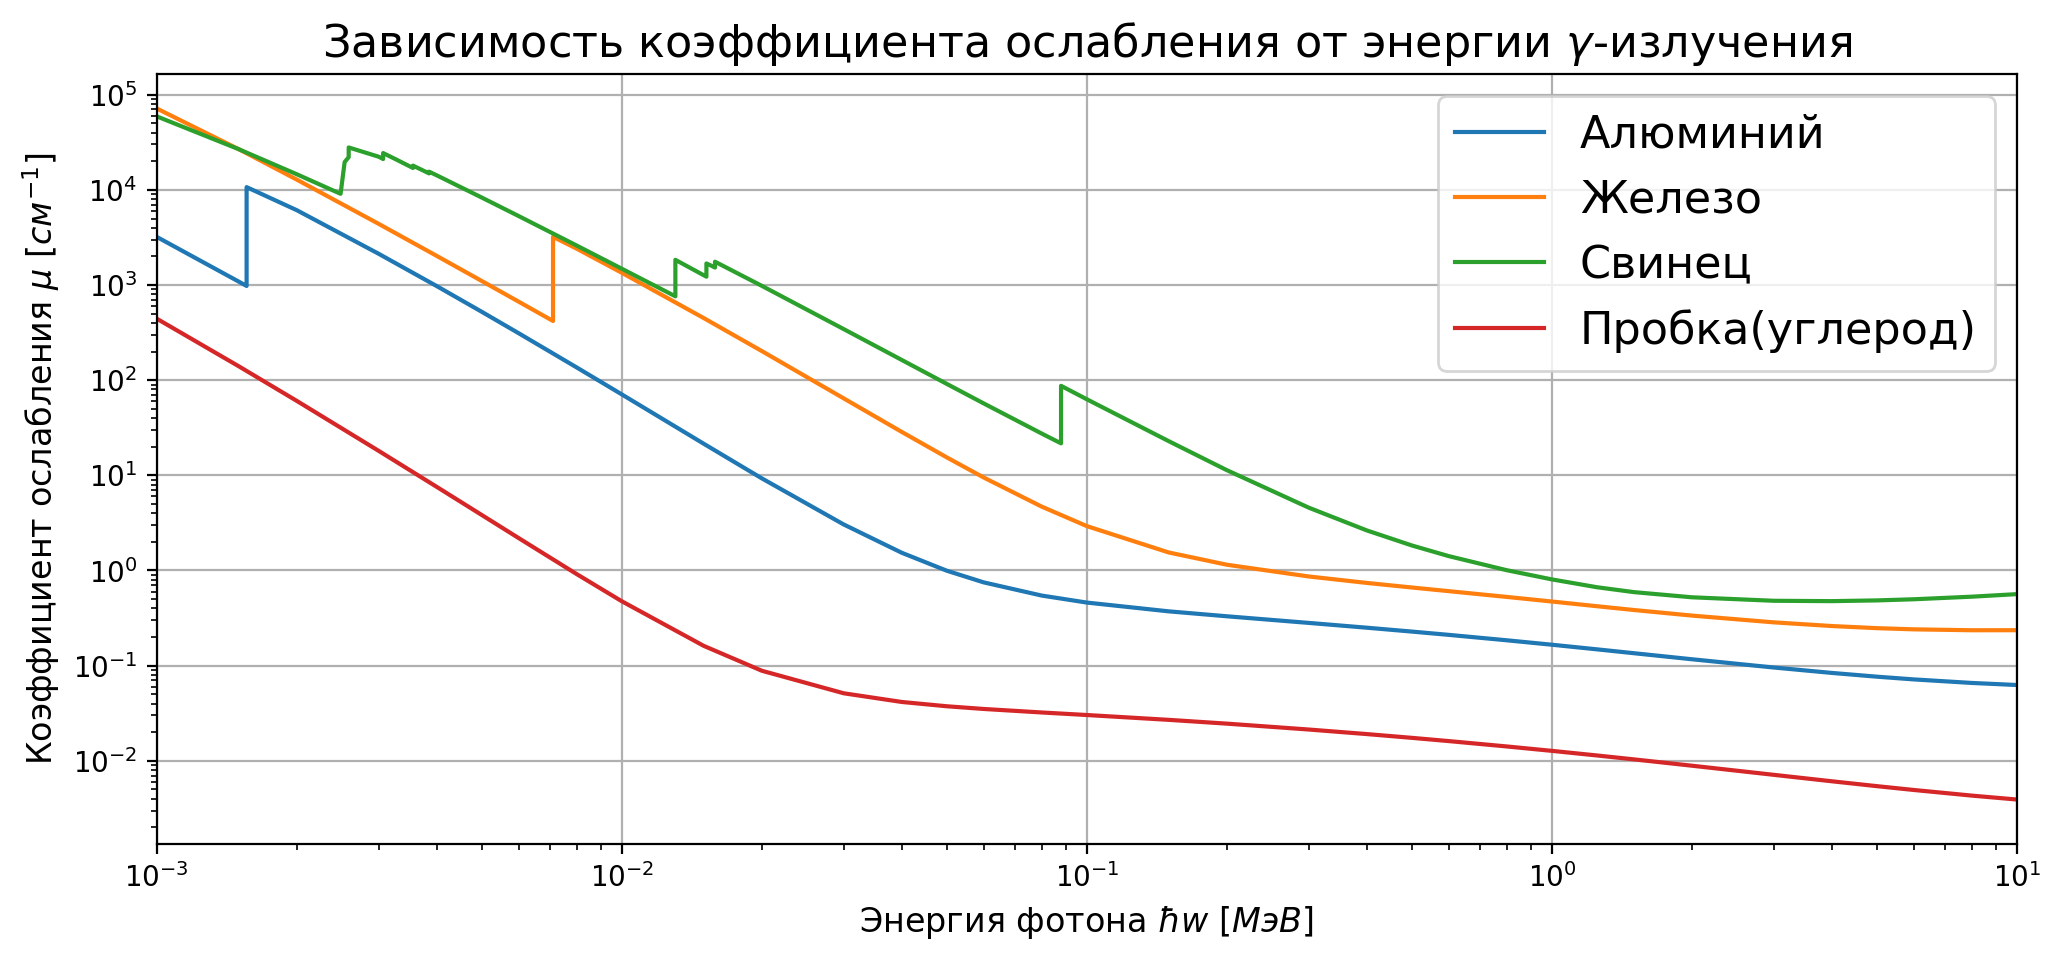

In [91]:
plt.figure(figsize = (12, 5), dpi = 200)
x_line = np.linspace(0.01, 19.98)

plt.loglog(data_Al.E, data_Al.mu_by_rho * 2.7, label = 'Алюминий')
plt.loglog(data_Fe.E, data_Fe.mu_by_rho * 7.874, label = 'Железо')
plt.loglog(data_Pb.E, data_Pb.mu_by_rho * 11.35, label = 'Свинец')
plt.loglog(data_C.E, data_C.mu_by_rho * 0.2, label = 'Пробка(углерод)')
plt.xlabel("Энергия фотона $\hbar w \ [МэВ]$", fontsize = 12)
plt.ylabel("Коэффициент ослабления $\mu \ [см^{-1}]$", fontsize = 12)
plt.legend(fontsize = 16)
plt.xlim(1e-3, 1e1)
plt.grid()
plt.title("Зависимость коэффициента ослабления от энергии $\gamma$-излучения", fontsize = 16)

In [108]:
attenuation_cols = [data_Al.mu_by_rho * 2.7, data_Fe.mu_by_rho * 7.874, data_Pb.mu_by_rho * 11.35, data_C.mu_by_rho * 0.2]
energy_cols = [data_Al.E, data_Fe.E, data_Pb.E, data_C.E]
names = ['Алюминий', 'Железо', 'Свинец', 'Пробка']
colors = cm.Set3(np.arange(5) / 4)
plt.figure(figsize = (12, 7), dpi = 200)
x_line = np.linspace(0.2, 2, 1000)
for name, att, E, color in zip(names, attenuation_cols, energy_cols, colors):
    mask = (E > 0.1) * (E < 3)
    f = interp1d(E[mask], att[mask], kind = 'quadratic')
    plt.plot(x_line, f(x_line), label = name, color = color)
    plt.axhline(result_mu[name][0], linestyle = '--', color = color, label = 'Экспериментальное значение')
    interception_x = x_line[np.argmin(np.abs(f(x_line) - result_mu[name][0]))]
    interception_right = x_line[np.argmin(np.abs(f(x_line) - result_mu[name][0] + result_mu[name][1]))]
    interception_left =  x_line[np.argmin(np.abs(f(x_line) - result_mu[name][0] - result_mu[name][1]))]
    plt.axvline(interception_x, color = 'black', linestyle = '--')
    plt.fill_between(x_line, 
                     y1 = [result_mu[name][0] + result_mu[name][1] for _ in x_line],
                     y2 = [result_mu[name][0] - result_mu[name][1] for _ in x_line],
                     color = color,
                     alpha = 0.6)
    plt.fill_betweenx(y = np.linspace(0, 2, 1000),
                      x1 = [interception_left for _ in range(1000)],
                      x2 = [interception_right for _ in range(1000)],
                      color = 'black',
                      alpha = 0.2)
    
plt.legend(fontsize = 12, ncols = 2, loc = 'upper left')
plt.xticks(np.arange(0.2, 2, 0.05))
plt.yticks(np.arange(0, 2, 0.05))
plt.xticks(np.arange(0.2, 2, 0.025), minor = True)
plt.grid(which = 'both')
plt.xlim(0.2, 1)
plt.ylim(0, 1.5)
plt.ylabel(r"Коэффициент ослабления $\mu \ см^{-1}$", fontsize = 16)
plt.xlabel(r"Энергия фотона $\hbar \omega \ МэВ$", fontsize = 16)

Text(0.5, 0, 'Энергия фотона $\\hbar \\omega \\ МэВ$')